In [15]:
import os
import torch
import torch.nn as nn
from torch.optim import Adam
import torchvision
from torchvision import transforms, datasets

import time

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

BATCH_SIZE    = 10
img_size      = 128
input_size    = img_size*img_size*3
orig_size     = img_size*img_size*3
latent_size   = 3
learning_rate = 1e-3
epochs        = 100

In [2]:
folder_path = 'data/'

def list_first_n_files_and_subfolders(directory_path, n=3):
    with os.scandir(directory_path) as entries:
        for entry in entries:
            if entry.is_dir():
                print(f"Directory: {entry.name}")
                # List the first 'n' files within the subfolder
                subfolder_path = os.path.join(directory_path, entry.name)
                with os.scandir(subfolder_path) as sub_entries:
                    for sub_entry in sub_entries:
                        if sub_entry.is_dir():
                            print(f"    |_ Sub-directory: {sub_entry.name}")
                            for i, item in enumerate(os.listdir(sub_entry.path)):
                                if i + 1 < n:
                                    print(f"       |_ File: {item}")
                                else:
                                    print(f"       |_ File: ....")
                                    break


list_first_n_files_and_subfolders(folder_path)

Directory: test
    |_ Sub-directory: nowildfire
       |_ File: -113.91777,50.901087.jpg
       |_ File: -113.91782,50.896917.jpg
       |_ File: ....
    |_ Sub-directory: wildfire
       |_ File: -59.03238,51.85132.jpg
       |_ File: -60.6867,50.26079.jpg
       |_ File: ....
Directory: test1
    |_ Sub-directory: nowildfire
       |_ File: -73.410756,45.457343.jpg
       |_ File: -73.413811,45.436142.jpg
       |_ File: ....
    |_ Sub-directory: wildfire
       |_ File: -64.1061,51.4492.jpg
       |_ File: -64.1526,50.27158.jpg
       |_ File: ....
Directory: train
    |_ Sub-directory: nowildfire
       |_ File: -113.917243,51.101323.jpg
       |_ File: -113.917264,50.966686.jpg
       |_ File: ....
    |_ Sub-directory: wildfire
       |_ File: -57.11902,51.47242.jpg
       |_ File: -57.8088,51.44634.jpg
       |_ File: ....
Directory: train1
    |_ Sub-directory: nowildfire
       |_ File: -73.408723,45.422591.jpg
       |_ File: -73.408779,45.636752.jpg
       |_ File: ....
 

In [3]:

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Resize images to a consistent size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0., 0., 0.], std=[1., 1., 1.])
])

train_dir = 'data/train1'
test_dir = 'data/test1'
valid_dir = 'data/valid1'

# Create datasets for training, validation, and test sets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=valid_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create DataLoader instances for each dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

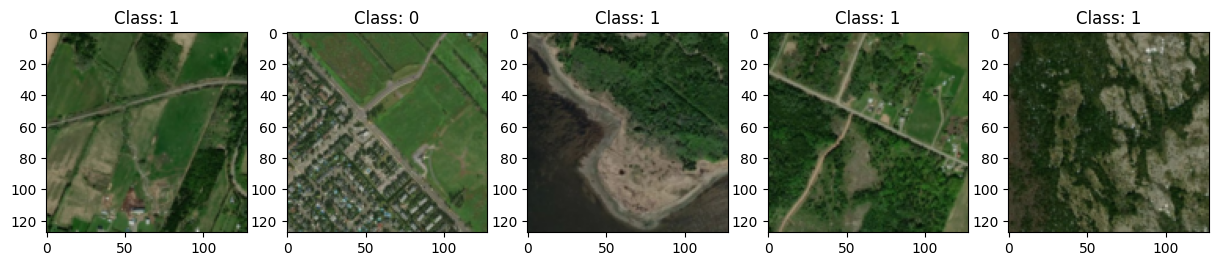

In [4]:
# Get the first batch from the DataLoader
dataiter = iter(train_loader)
for batch in enumerate(train_loader):
    step, [images, labels] = batch
    break

labels

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    ax = axes[i]
    ax.imshow(torchvision.utils.make_grid(images[i]).numpy().transpose((1, 2, 0)))
    ax.set_title(f'Class: {labels[i].item()}')

plt.show()

<b>Auto-encoder</b>

In [63]:
input_size    = img_size*img_size*3
orig_size     = img_size*img_size*3
latent_size   = 2
learning_rate = 1e-3
epochs        = 100

class Encoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super(Encoder, self).__init__()
        self.flat      = nn.Flatten()
        self.fc1       = nn.Linear(input_size, 1000)
        self.bn1       = nn.BatchNorm1d(1000)
        self.fc2       = nn.Linear(1000, 500)
        self.bn2       = nn.BatchNorm1d(500)
        self.fc3       = nn.Linear(500, 300)
        self.bn3       = nn.BatchNorm1d(300)
        self.fc4       = nn.Linear(300, 100)
        self.bn4       = nn.BatchNorm1d(100)
        self.fc_mu     = nn.Linear(100, latent_size)
        self.fc_logvar = nn.Linear(100, latent_size)

    def forward(self, x):
        x              = torch.relu(self.flat(x))
        x              = torch.relu(self.bn1(self.fc1(x)))
        x              = torch.relu(self.bn2(self.fc2(x)))
        x              = torch.relu(self.bn3(self.fc3(x)))
        x              = torch.relu(self.bn4(self.fc4(x)))
        mu             = self.fc_mu(x)
        logvar         = self.fc_logvar(x)
        return mu, logvar

# Assuming x is your input tensor
x = torch.randn([BATCH_SIZE, 3, img_size, img_size])

encoder = Encoder(input_size= input_size, latent_size=latent_size)
mu, logvar = encoder(x)
print(mu.shape)
print(logvar.shape)

torch.Size([10, 2])
torch.Size([10, 2])


In [64]:
class Decoder(nn.Module):
    def __init__(self, latent_size, orig_size):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size,100)
        self.bn1 = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100,300)
        self.bn2 = nn.BatchNorm1d(300)
        self.fc3 = nn.Linear(300,500)
        self.bn3 = nn.BatchNorm1d(500)
        self.fc4 = nn.Linear(500, 1000)
        self.bn4 = nn.BatchNorm1d(1000)
        self.fc5 = nn.Linear(1000, orig_size)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = torch.relu(self.bn3(self.fc3(x)))
        x = torch.relu(self.bn4(self.fc4(x)))
        x = torch.sigmoid(self.fc5(x))
        return x.view(10, 3, img_size, img_size)

# Assuming x is your input tensor
x = torch.randn([BATCH_SIZE, 2])

decoder = Decoder(latent_size= latent_size, orig_size=orig_size)
output = decoder(x)
print(output.shape)


torch.Size([10, 3, 128, 128])


In [69]:

class Encoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super(Encoder, self).__init__()
        self.flat      = nn.Flatten()
        self.fc1       = nn.Linear(input_size, 1000)
        self.bn1       = nn.BatchNorm1d(1000)
        self.fc2       = nn.Linear(1000, 500)
        self.bn2       = nn.BatchNorm1d(500)
        self.fc3       = nn.Linear(500, 300)
        self.bn3       = nn.BatchNorm1d(300)
        self.fc4       = nn.Linear(300, 100)
        self.bn4       = nn.BatchNorm1d(100)
        self.fc_mu     = nn.Linear(100, latent_size)
        self.fc_logvar = nn.Linear(100, latent_size)

    def forward(self, x):
        x              = torch.relu(self.flat(x))
        x              = torch.relu(self.bn1(self.fc1(x)))
        x              = torch.relu(self.bn2(self.fc2(x)))
        x              = torch.relu(self.bn3(self.fc3(x)))
        x              = torch.relu(self.bn4(self.fc4(x)))
        mu             = self.fc_mu(x)
        logvar         = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_size, orig_size):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size,100)
        self.bn1 = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100,300)
        self.bn2 = nn.BatchNorm1d(300)
        self.fc3 = nn.Linear(300,500)
        self.bn3 = nn.BatchNorm1d(500)
        self.fc4 = nn.Linear(500, 1000)
        self.bn4 = nn.BatchNorm1d(1000)
        self.fc5 = nn.Linear(1000, orig_size)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = torch.relu(self.bn3(self.fc3(x)))
        x = torch.relu(self.bn4(self.fc4(x)))
        x = torch.sigmoid(self.fc5(x))
        return x.view(BATCH_SIZE, 3, img_size, img_size)

class VAE(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(VAE, self).__init__()
        self.encoder = Encoder
        self.decoder = Decoder
    
    def reparameterization(self, mu, log_var):
        epsilon = torch.randn_like(log_var)      
        z = mu + log_var*epsilon
        return z
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = self.reparameterization(mu, torch.exp(0.5 * log_var))
        reconstruction = self.decoder(z)
        return mu, log_var, reconstruction

encoder = Encoder(input_size=input_size,latent_size=latent_size)
decoder = Decoder(latent_size=latent_size, orig_size=input_size)
model = VAE(Encoder=encoder, Decoder=decoder)

In [70]:
mse_loss = nn.MSELoss(reduction="sum")

def loss_function(x, x_hat, mean, log_var):
    loss_mse = mse_loss(x_hat, x)
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return loss_mse + KLD

optimizer = Adam(model.parameters(), lr=learning_rate)

In [71]:
# Training loop
model.train()
train_losses_dense = []
for epoch in range(epochs):
    start_time = time.time()
    overall_loss = 0
    batch_idx=0
    for batch in train_loader:
        batch_idx += 1
        optimizer.zero_grad()
        x_batch = batch[0]
        mu, log_var, x_recon = model(x_batch)

        # Reconstruction loss + KL divergence
        loss = loss_function(x_batch, x_recon, mu, log_var)
        # print(loss.item())
        overall_loss += loss.item()/ (BATCH_SIZE*img_size*img_size)
        loss.backward()
        optimizer.step()
    train_losses_dense.append(overall_loss / batch_idx)
    epoch_time = time.time() - start_time

    # Print progress
    if epoch % 2 == 0:
        print(f"\tEpoch {epoch} complete!\tAverage Loss: {(overall_loss / batch_idx):.2f}\t Time training: {epoch_time/60:.1f} mins")

	Epoch 0 complete!	Average Loss: 999505463.20	 Time training: 56 seconds
	Epoch 2 complete!	Average Loss: 728955360.00	 Time training: 52 seconds
	Epoch 4 complete!	Average Loss: 699154504.80	 Time training: 57 seconds
	Epoch 6 complete!	Average Loss: 700817141.60	 Time training: 48 seconds
	Epoch 8 complete!	Average Loss: 696560317.60	 Time training: 56 seconds
	Epoch 10 complete!	Average Loss: 687645018.40	 Time training: 52 seconds
	Epoch 12 complete!	Average Loss: 677748539.20	 Time training: 53 seconds
	Epoch 14 complete!	Average Loss: 671676632.00	 Time training: 50 seconds
	Epoch 16 complete!	Average Loss: 664578696.80	 Time training: 50 seconds
	Epoch 18 complete!	Average Loss: 656944733.20	 Time training: 54 seconds
	Epoch 20 complete!	Average Loss: 650577489.20	 Time training: 48 seconds
	Epoch 22 complete!	Average Loss: 656017144.80	 Time training: 49 seconds
	Epoch 24 complete!	Average Loss: 633365002.00	 Time training: 49 seconds
	Epoch 26 complete!	Average Loss: 633535670

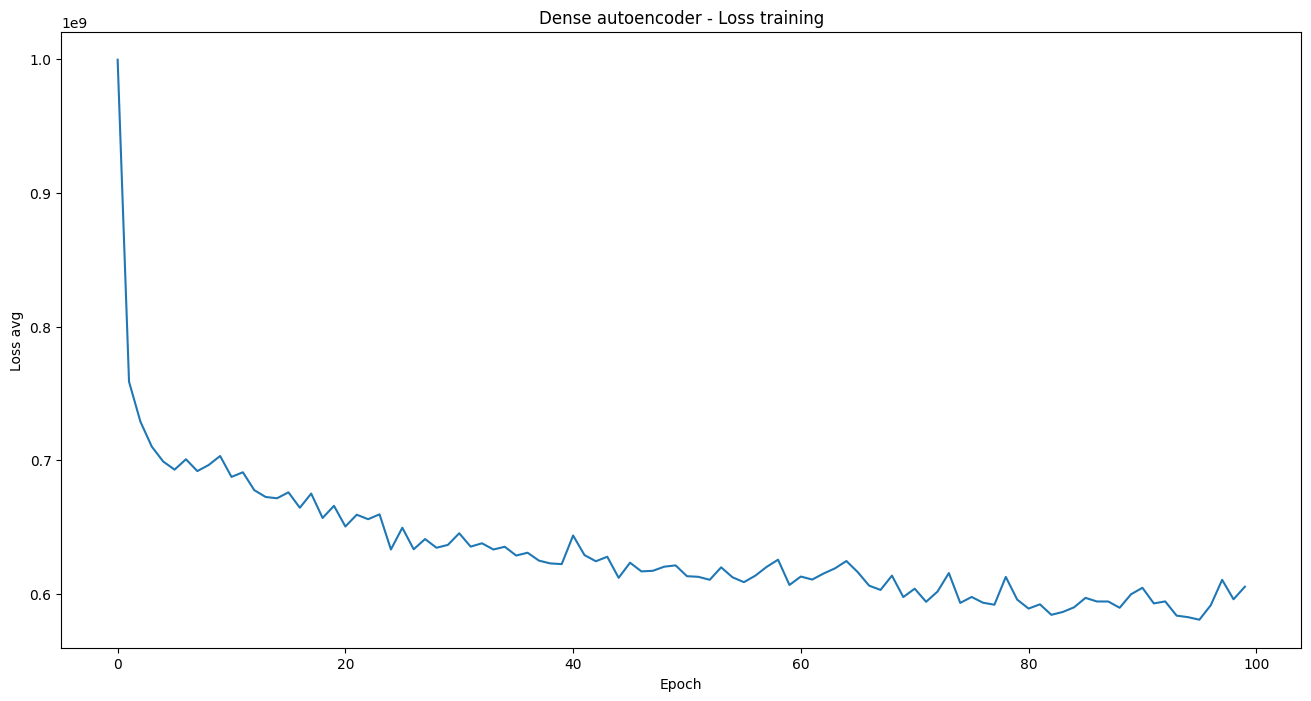

In [73]:
plt.figure(figsize=(16,8))
plt.plot(train_losses_dense)
plt.title("Dense autoencoder - Loss training")
plt.xlabel("Epoch")
plt.ylabel("Loss avg")
plt.show()

<b>Conv. autoencoder</b>

In [210]:
class ConvEncoder(nn.Module):
    def __init__(self, input_channels, latent_size):
        super(ConvEncoder, self).__init__()
        self.conv1     = nn.Conv2d(input_channels, 128, stride=2, kernel_size=3, padding=1) #64
        self.bn1       = nn.BatchNorm2d(128)
        self.conv2     = nn.Conv2d(128, 256, stride=2, kernel_size=3, padding=1)             #32
        self.bn2       = nn.BatchNorm2d(256)
        self.conv3     = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)            #16
        self.bn3       = nn.BatchNorm2d(512)
        self.conv4     = nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1)           #8
        self.bn4       = nn.BatchNorm2d(1024)
        self.conv5     = nn.Conv2d(1024, 2056, kernel_size=3, stride=2, padding=1)           #4
        self.bn5       = nn.BatchNorm2d(2056)
        self.conv6     = nn.Conv2d(2056, 4096, kernel_size=3, stride=2, padding=1)          #2
        self.bn6       = nn.BatchNorm2d(4096)
        self.flat      = nn.Flatten()
        self.lin       = nn.Linear(16384, 2056)
        self.fc_mu     = nn.Linear(2056, latent_size)
        self.fc_logvar = nn.Linear(2056, latent_size)

    
    def forward(self, x):
        x              = torch.relu(self.bn1(self.conv1(x)))
        x              = torch.relu(self.bn2(self.conv2(x)))
        x              = torch.relu(self.bn3(self.conv3(x)))
        x              = torch.relu(self.bn4(self.conv4(x)))
        x              = torch.relu(self.bn5(self.conv5(x)))
        x              = torch.relu(self.bn6(self.conv6(x)))
        x              = torch.relu(self.flat(x))
        x              = torch.relu(self.lin(x))
        mu             = self.fc_mu(x)
        logvar         = self.fc_logvar(x)
        return mu, logvar
        # return x

input_channels = 3

# Assuming x is your input tensor
x = torch.randn([BATCH_SIZE, input_channels, img_size, img_size])

# Modify input_channels to match the number of channels in the reshaped tensor
conv_encoder = ConvEncoder(input_channels=3, latent_size=latent_size)
output1, output2 = conv_encoder(x)
# output1 = conv_encoder(x)
print(output1.shape)

torch.Size([10, 10])


In [211]:
class ConvDecoder(nn.Module):
    def __init__(self, output_channels, latent_size):
        super(ConvDecoder, self).__init__()
        self.lin1    = nn.Linear(latent_size, 100)
        self.lin2    = nn.Linear(100, 16384)
        self.bn1     = nn.BatchNorm1d(16384)
        self.deconv1 = nn.ConvTranspose2d(4096, 2056, kernel_size=3, stride=2, padding=1, output_padding=1) #4
        self.bn2     = nn.BatchNorm2d(2056)
        self.deconv2 = nn.ConvTranspose2d(2056, 1024, kernel_size=3, stride=2, padding=1, output_padding=1)  #8
        self.bn3     = nn.BatchNorm2d(1024)
        self.deconv3 = nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1)  #16
        self.bn4     = nn.BatchNorm2d(512)
        self.deconv4 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)   #32
        self.bn5     = nn.BatchNorm2d(256)
        self.deconv5 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)    #64
        self.bn6     = nn.BatchNorm2d(128)
        self.deconv6 = nn.ConvTranspose2d(128, 3, kernel_size=3, stride=2, padding=1, output_padding=1)    #128
        self.bn7     = nn.BatchNorm2d(3)
    
    def forward(self, x):
        x = torch.relu(self.lin1(x))
        x = torch.relu(self.bn1(self.lin2(x)))
        x = x.view(BATCH_SIZE, 4096, 2, 2)
        x = torch.relu(self.bn2(self.deconv1(x)))
        x = torch.relu(self.bn3(self.deconv2(x)))
        x = torch.relu(self.bn4(self.deconv3(x)))
        x = torch.relu(self.bn5(self.deconv4(x)))
        x = torch.relu(self.bn6(self.deconv5(x)))
        x = torch.relu(self.bn7(self.deconv6(x)))
        return x

x = torch.randn([BATCH_SIZE, latent_size])
conv_decoder = ConvDecoder(output_channels=3, latent_size=latent_size)
output1 = conv_decoder(x)
print(output1.shape)

torch.Size([10, 3, 128, 128])


In [34]:
class ConvEncoder(nn.Module):
    def __init__(self, input_channels, latent_size):
        super(ConvEncoder, self).__init__()
        self.conv1     = nn.Conv2d(input_channels, 128, stride=2, kernel_size=3, padding=1) #64
        self.bn1       = nn.BatchNorm2d(128)
        self.conv2     = nn.Conv2d(128, 256, stride=2, kernel_size=3, padding=1)             #32
        self.bn2       = nn.BatchNorm2d(256)
        self.conv3     = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)            #16
        self.bn3       = nn.BatchNorm2d(512)
        self.conv4     = nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1)           #8
        self.bn4       = nn.BatchNorm2d(1024)
        self.conv5     = nn.Conv2d(1024, 2056, kernel_size=3, stride=2, padding=1)           #4
        self.bn5       = nn.BatchNorm2d(2056)
        self.conv6     = nn.Conv2d(2056, 4096, kernel_size=3, stride=2, padding=1)          #2
        self.bn6       = nn.BatchNorm2d(4096)
        self.flat      = nn.Flatten()
        self.lin       = nn.Linear(16384, 4096)
        self.fc_mu     = nn.Linear(4096, latent_size)
        self.fc_logvar = nn.Linear(4096, latent_size)

    
    def forward(self, x):
        x              = torch.relu(self.bn1(self.conv1(x)))
        x              = torch.relu(self.bn2(self.conv2(x)))
        x              = torch.relu(self.bn3(self.conv3(x)))
        x              = torch.relu(self.bn4(self.conv4(x)))
        x              = torch.relu(self.bn5(self.conv5(x)))
        x              = torch.relu(self.bn6(self.conv6(x)))
        x              = torch.relu(self.flat(x))
        x              = torch.relu(self.lin(x))
        mu             = self.fc_mu(x)
        logvar         = self.fc_logvar(x)
        return mu, logvar

class ConvDecoder(nn.Module):
    def __init__(self, output_channels, latent_size):
        super(ConvDecoder, self).__init__()
        self.lin1    = nn.Linear(latent_size, 4096)
        self.lin2    = nn.Linear(4096, 16384)
        self.bn1     = nn.BatchNorm1d(16384)
        self.deconv1 = nn.ConvTranspose2d(4096, 2056, kernel_size=3, stride=2, padding=1, output_padding=1) #4
        self.bn2     = nn.BatchNorm2d(2056)
        self.deconv2 = nn.ConvTranspose2d(2056, 1024, kernel_size=3, stride=2, padding=1, output_padding=1)  #8
        self.bn3     = nn.BatchNorm2d(1024)
        self.deconv3 = nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1)  #16
        self.bn4     = nn.BatchNorm2d(512)
        self.deconv4 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)   #32
        self.bn5     = nn.BatchNorm2d(256)
        self.deconv5 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)    #64
        self.bn6     = nn.BatchNorm2d(128)
        self.deconv6 = nn.ConvTranspose2d(128, 3, kernel_size=3, stride=2, padding=1, output_padding=1)    #128
        self.bn7     = nn.BatchNorm2d(3)
    
    def forward(self, x):
        x = torch.relu(self.lin1(x))
        x = torch.relu(self.bn1(self.lin2(x)))
        x = x.view(BATCH_SIZE, 4096, 2, 2)
        x = torch.relu(self.bn2(self.deconv1(x)))
        x = torch.relu(self.bn3(self.deconv2(x)))
        x = torch.relu(self.bn4(self.deconv3(x)))
        x = torch.relu(self.bn5(self.deconv4(x)))
        x = torch.relu(self.bn6(self.deconv5(x)))
        x = torch.relu(self.bn7(self.deconv6(x)))
        return x

class ConvVAE(nn.Module):
    def __init__(self, ConvEncoder, ConvDecoder):
        super(ConvVAE, self).__init__()
        self.encoder = ConvEncoder
        self.decoder = ConvDecoder
    
    def reparameterization(self, mu, log_var):
        epsilon = torch.randn_like(log_var)      
        z = mu + log_var * epsilon
        return z
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterization(mu, torch.exp(0.5 * log_var))
        reconstruction = self.decoder(z)
        return mu, log_var, reconstruction, z

input_channels = 3

conv_encoder = ConvEncoder(input_channels=input_channels, latent_size=latent_size)
conv_decoder = ConvDecoder(output_channels=input_channels, latent_size=latent_size)
model = ConvVAE(ConvEncoder=conv_encoder, ConvDecoder=conv_decoder)

In [35]:
mse_loss = nn.MSELoss(reduction="sum")

def loss_function(x, x_hat, mean, log_var):
    loss_mse = mse_loss(x_hat, x)
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return loss_mse + KLD

optimizer = Adam(model.parameters(), lr=learning_rate)

In [36]:

train_losses_conv = []
val_losses_conv = []
prev_val_loss = float('inf')
patience = 5
counter = 0
start_time = time.time()
for epoch in range(20):
    # Training
    model.train()
    start_time1 = time.time()
    overall_loss = 0
    batch_idx=0
    for batch in train_loader:
        batch_idx += 1
        optimizer.zero_grad()
        x_batch = batch[0]
        mu, log_var, x_recon, z = model(x_batch)

        # Reconstruction loss + KL divergence
        loss = loss_function(x_batch, x_recon, mu, log_var)
        # print(loss.item())
        loss_i = loss.item() / (BATCH_SIZE*img_size*img_size)
        loss.backward()
        overall_loss += loss_i

        optimizer.step()

    train_losses_conv.append(overall_loss / batch_idx)
    epoch_time_training = time.time() - start_time1
    training_time = time.time()-start_time
    print(f"Epoch {epoch} \tTraining Loss: {(overall_loss / batch_idx):.3f}\tTime elapsed: {training_time/60:.1f} min\tEpoch time: {epoch_time_training/60:.1f} min")

    # Evaluation
    model.eval()
    with torch.no_grad():
        start_time2 = time.time()
        val_loss = 0
        batch_idx2 = 0
        for batch in val_loader:
            batch_idx2 += 1
            x_batch = batch[0]
            mu, log_var, x_recon, z = model(x_batch)
            loss_i = loss_function(x_batch, x_recon, mu, log_var).item()/ (BATCH_SIZE*img_size*img_size)
            val_loss += loss_i
        val_loss_epoch = val_loss/batch_idx2
        val_losses_conv.append(val_loss_epoch)
        epoch_time_validation = time.time() - start_time2
        validation_time = time.time()-start_time
        print(f"Epoch {epoch} \tValidation Loss: {val_loss_epoch:.3f}\tTime elapsed: {validation_time/60:.1f} min\tEpoch time: {epoch_time_validation/60:.1f} min")
        # Save the model every epoch
        # torch.save(model.state_dict(), f"model_epoch_{epoch}.pth")
        
        if val_loss_epoch < prev_val_loss:
            prev_val_loss = val_loss_epoch
            counter = 0
            best_model_state = model.state_dict()
        else:
            counter +=1
            if counter == patience:
                break
    model.train()

if best_model_state is not None:
    model.load_state_dict(best_model_state)


Epoch 0 	Training Loss: 52.956	Time elapsed: 5.7 min	Epoch time: 5.7 min
Epoch 0 	Validation Loss: 0.130	Time elapsed: 5.9 min	Epoch time: 0.2 min
Epoch 1 	Training Loss: 0.106	Time elapsed: 11.6 min	Epoch time: 5.7 min
Epoch 1 	Validation Loss: 0.124	Time elapsed: 11.8 min	Epoch time: 0.2 min
Epoch 2 	Training Loss: 0.083	Time elapsed: 17.6 min	Epoch time: 5.8 min
Epoch 2 	Validation Loss: 0.116	Time elapsed: 17.8 min	Epoch time: 0.2 min
Epoch 3 	Training Loss: 0.097	Time elapsed: 23.6 min	Epoch time: 5.8 min
Epoch 3 	Validation Loss: 0.122	Time elapsed: 23.8 min	Epoch time: 0.2 min
Epoch 4 	Training Loss: 0.108	Time elapsed: 29.9 min	Epoch time: 6.1 min
Epoch 4 	Validation Loss: 0.112	Time elapsed: 30.0 min	Epoch time: 0.2 min
Epoch 5 	Training Loss: 0.965	Time elapsed: 35.8 min	Epoch time: 5.7 min
Epoch 5 	Validation Loss: 0.151	Time elapsed: 35.9 min	Epoch time: 0.2 min
Epoch 6 	Training Loss: 0.128	Time elapsed: 41.1 min	Epoch time: 5.2 min
Epoch 6 	Validation Loss: inf	Time elaps

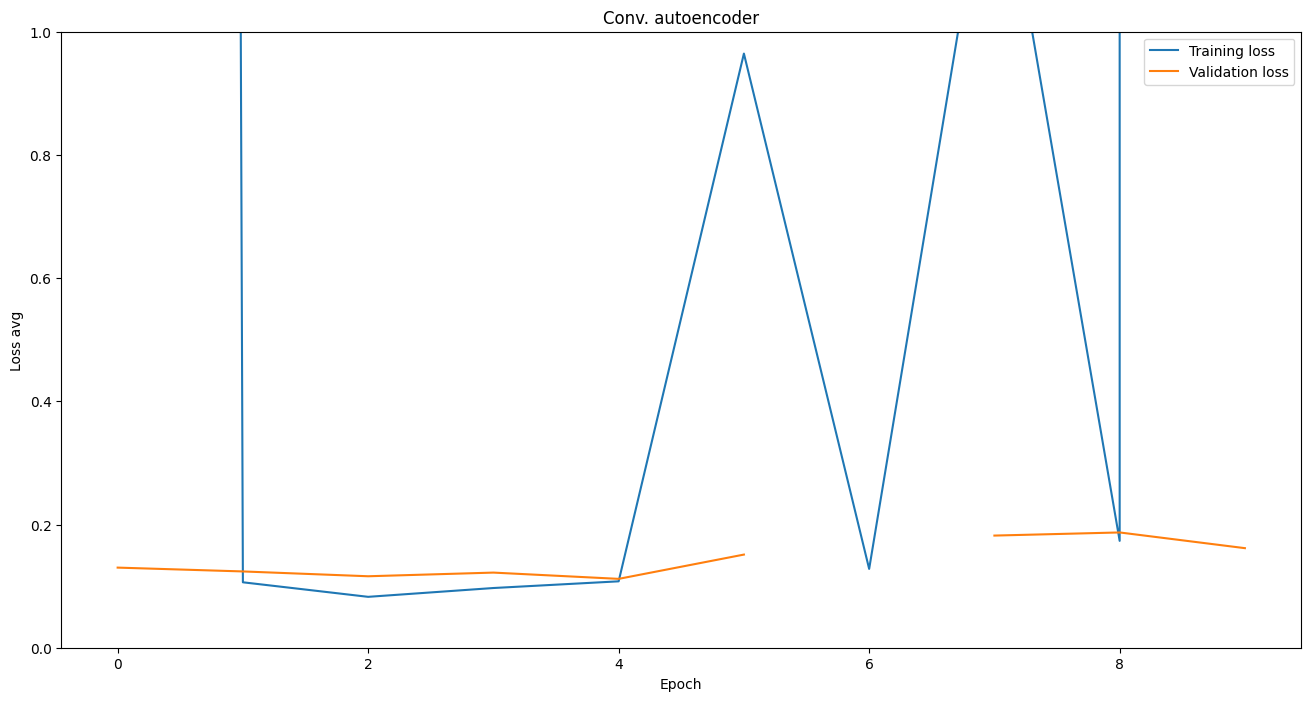

In [41]:
plt.figure(figsize=(16,8))
plt.plot(train_losses_conv, label='Training loss')
plt.plot(val_losses_conv, label='Validation loss')
plt.title("Conv. autoencoder")
plt.xlabel("Epoch")
plt.ylabel("Loss avg")
plt.ylim(0,1)
plt.legend()
plt.show()

In [40]:
classes = val_dataset.classes
z_space     = []
true_labels = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        data = batch[0]
        labels = batch[1]
        optimizer.zero_grad()
        mu, log_var, embeddings, z = model(data)
        z_space.append(z)
        true_labels.append(labels)
        labels_result = torch.cat(true_labels, dim=0)
        z_result = torch.cat(z_space, dim=0)

import plotly.graph_objects as go

# Assuming mu_result is a 2D NumPy array or tensor with shape (num_samples, 3)
z_coord       = z_result[:, 0].numpy()
x_coord       = z_result[:, 1].numpy()
y_coord       = z_result[:, 2].numpy()
labels_result = labels_result.detach().cpu().numpy()

# Assuming label_names is a list of string labels corresponding to each point
label_names = [classes[label] for label in labels_result]
# label_names = [top_k_cust[label] for label in labels]

# Create a 3D scatter plot with hover text
fig = go.Figure(data=[
    go.Scatter3d(
        x=x_coord, y=y_coord, z=z_coord,
        mode='markers',
        marker=dict(color=labels_result, colorscale='Viridis', size=5),
        text=label_names,  # Specify hover text
        hoverinfo='text'  # Show only text on hover
    )
])

# Customize the layout with a size of 12x8
fig.update_layout(
    scene=dict(aspectmode="data"),
    width=1200,  # Set width to 1200 pixels
    height=800   # Set height to 800 pixels
)

# Show the plot
fig.show()